In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

Nesse modelo, foram feitas as seguintes modificações em relações aos demais:

Primeiro, foi removido $I_{H0}$ e $I_{M0}$ das equações diferenciais. 

Segundo, as equações de $\dfrac{dE_M}{dt}$ e $\dfrac{dI_M}{dt}$ foram modificadas, para que utilizem auma nova taxa, $b_3$, de modo a corrigir a transferência de mosquitos do compartimento $E$ para $I$, já que não é necessária a ocorrência de novo contato com humano infectado para a conversão de $E_M$ para $I_M$. 

In [2]:
def model(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T1 - T_curr) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - a_curr * b3_curr * E_M * l_curr
    dImdt = a_curr * b3_curr * E_M * l_curr - mu_curr * I_M
    
#     print(dSmdt)
#     print(dEmdt)
#     print(dImdt)
#     print(' ')
    
    #print(b_curr - mu_curr*M)
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [3]:
T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=36.5
b1=0.1

A=317.925
B=15
C=-48.78

b2=0.3
tau_H=10
DD=105
Tmin=14.5
gamma= 1/1825 
R_L = 312
N = 8558
M = 300000 
E_M0 = 50000
I_H0 = 1000 
I_M0 = 2500
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0 - I_M0

In [4]:
# Funções de temperatura e chuva fora do contexto da função lotkavolterra
def T(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

def R(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

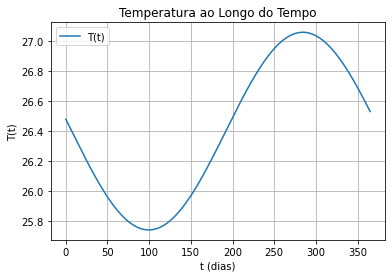

In [5]:
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
T_values = [T(t) for t in t_values]

# Plotando
plt.plot(t_values, T_values, label='T(t)')
plt.title('Temperatura ao Longo do Tempo')
plt.xlabel('t (dias)')
plt.ylabel('T(t)')
plt.legend()
plt.grid(True)
plt.show()

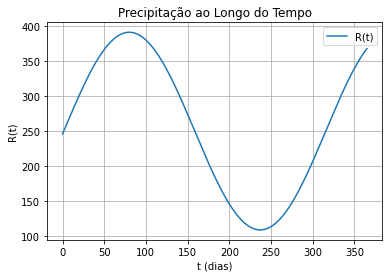

In [6]:
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
R_values = [R(t) for t in t_values]

# Plotando
plt.plot(t_values, R_values, label='R(t)')
plt.title('Precipitação ao Longo do Tempo')
plt.xlabel('t (dias)')
plt.ylabel('R(t)')
plt.legend()
plt.grid(True)
plt.show()

Analisando a modelagem de humanos com dados originais, é possível ver que o modelo fica de forma bem diferente do que era utilizando $I_{H0}$ e $I_{M0}$ nas EDOs, em especial na modelagem de humanos.

In [7]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

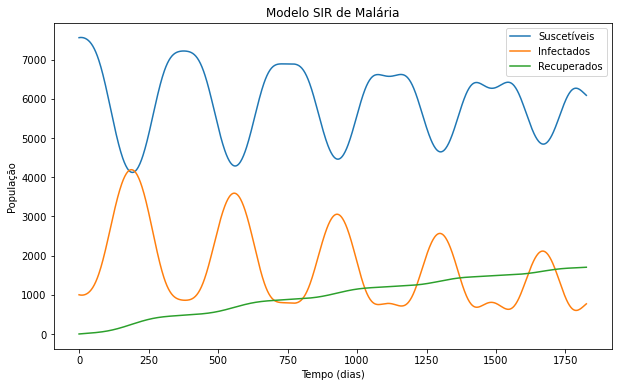

In [8]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

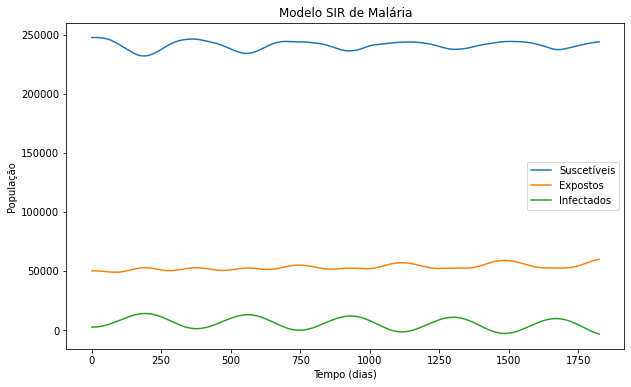

In [9]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Modificando $A, \ B$ e $C$:

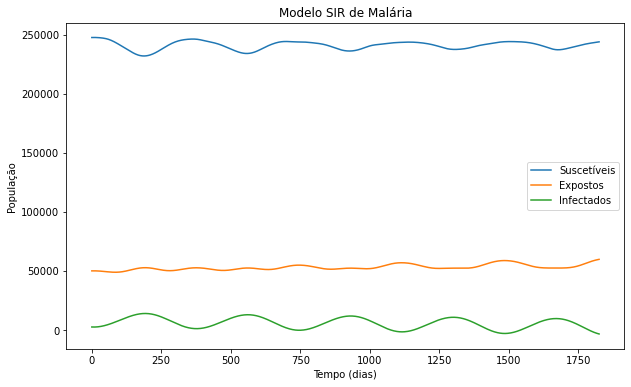

In [10]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 298.5, 11.7, -48, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Testando efeito de $A$ muito grande:

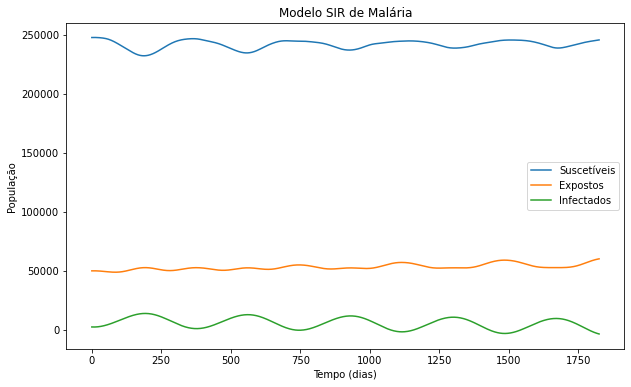

In [11]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 1298.5, 11.7, -48, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Aumentar $A$ não parece modificar muito o equilíbrio de mosquitos.

Testando efeito de $A$ muito pequeno:

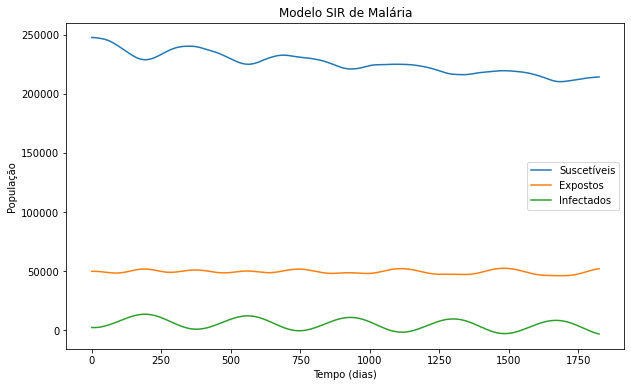

In [12]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 18.5, 11.7, -48, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

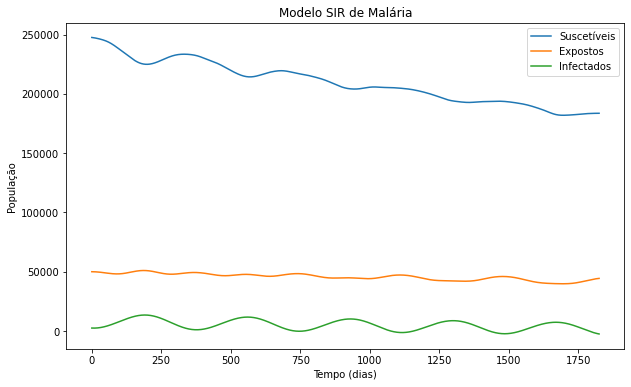

In [13]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 8.5, 11.7, -48, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [14]:
min(I_M)

-2494.297390964154

Diminuir $A$ fará com que a população diminua ao longo do tempo. O número de infectados acaba ficando negativo

In [15]:
A

317.925000000000

In [16]:
B

15

In [17]:
C

-48.7800000000000

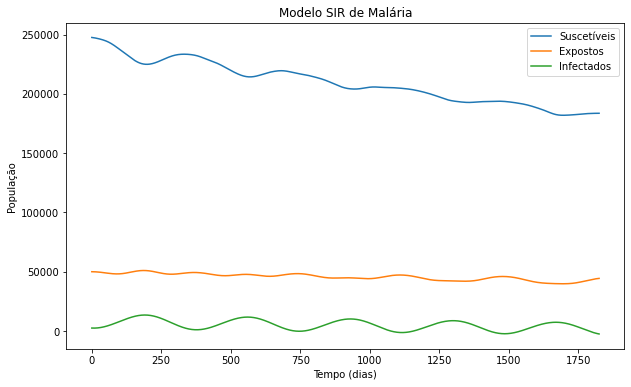

In [18]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Estimando valores de $\mu$ para diferentes $A, \ B$ e $C$:

In [19]:
# Novos valores de A, B e C
A_novo = -1000
B_novo = 10
C_novo = -50

# Função para calcular T(t) com os novos valores de A, B e C
def T_novo(t):
    return T1 * (1 + T2 * np.cos(omega1 * t - phi1))

# Calcular mu usando os novos valores de A, B, C e T(t)
def calcular_mu_novo(t):
    return 1 / (A_novo * T_novo(t)**2 + B_novo * T_novo(t) + C_novo)

# Calcular mu para o dado t usando os novos valores de A, B, C
t_valor = 0  # Vamos calcular para t = 0
mu_novo = calcular_mu_novo(t_valor)

print("Novo valor de mu para t = 0:", mu_novo)

Novo valor de mu para t = 0: -1.4266336310907504e-06


In [20]:
# Novos valores de A, B e C
A_novo = -10
B_novo = 100
C_novo = -25

# Função para calcular T(t) com os novos valores de A, B e C
def T_novo(t):
    return T1 * (1 + T2 * np.cos(omega1 * t - phi1))

# Calcular mu usando os novos valores de A, B, C e T(t)
def calcular_mu_novo(t):
    return 1 / (A_novo * T_novo(t)**2 + B_novo * T_novo(t) + C_novo)

# Calcular mu para o dado t usando os novos valores de A, B, C
t_valor = 0  # Vamos calcular para t = 0
mu_novo = calcular_mu_novo(t_valor)

print("Novo valor de mu para t = 0:", mu_novo)

Novo valor de mu para t = 0: -0.00022785775851987173


In [21]:
# Novos valores de A, B e C
A_novo = -1800.5
B_novo = 11.7
C_novo = -48

# Função para calcular T(t) com os novos valores de A, B e C
def T_novo(t):
    return T1 * (1 + T2 * np.cos(omega1 * t - phi1))

# Calcular mu usando os novos valores de A, B, C e T(t)
def calcular_mu_novo(t):
    return 1 / (A_novo * T_novo(t)**2 + B_novo * T_novo(t) + C_novo)

# Calcular mu para o dado t usando os novos valores de A, B, C
t_valor = 0  # Vamos calcular para t = 0
mu_novo = calcular_mu_novo(t_valor)

print("Novo valor de mu para t = 0:", mu_novo)

Novo valor de mu para t = 0: -7.922757156718842e-07


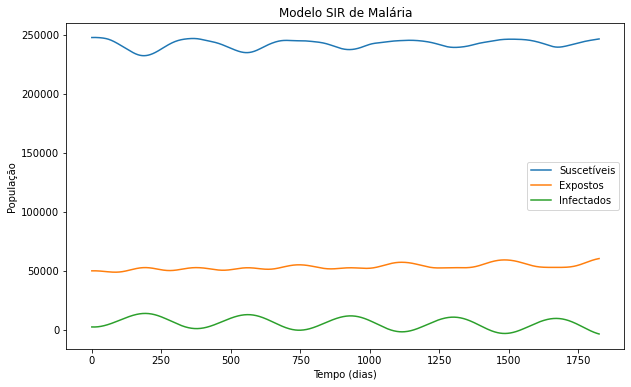

In [22]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -1800.5, 11.7, -48, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

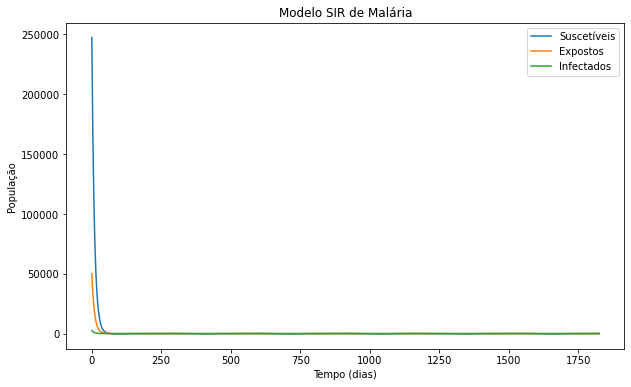

In [23]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -0.03, 1.31, -4.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [24]:
# Novos valores de A, B e C
A_novo = -0.03
B_novo = 1.31
C_novo = -4.4

# Função para calcular T(t) com os novos valores de A, B e C
def T_novo(t):
    return T1 * (1 + T2 * np.cos(omega1 * t - phi1))

# Calcular mu usando os novos valores de A, B, C e T(t)
def calcular_mu_novo(t):
    return 1 / (A_novo * T_novo(t)**2 + B_novo * T_novo(t) + C_novo)

# Calcular mu para o dado t usando os novos valores de A, B, C
t_valor = 0  # Vamos calcular para t = 0
mu_novo = calcular_mu_novo(t_valor)

print("Novo valor de mu para t = 0:", mu_novo)

Novo valor de mu para t = 0: 0.10807050518217226


Usando os valores originais de $A, \ B$ e $C$ do artigo, a população rapidamente decai, visto que a taxa de mortalidade fica com um valor positivo

In [25]:
# Novos valores de A, B e C
A_novo = -0.3
B_novo = 1.31
C_novo = -4.4

# Função para calcular T(t) com os novos valores de A, B e C
def T_novo(t):
    return T1 * (1 + T2 * np.cos(omega1 * t - phi1))

# Calcular mu usando os novos valores de A, B, C e T(t)
def calcular_mu_novo(t):
    return 1 / (A_novo * T_novo(t)**2 + B_novo * T_novo(t) + C_novo)

# Calcular mu para o dado t usando os novos valores de A, B, C
t_valor = 0  # Vamos calcular para t = 0
mu_novo = calcular_mu_novo(t_valor)

print("Novo valor de mu para t = 0:", mu_novo)

Novo valor de mu para t = 0: -0.005553658208357254


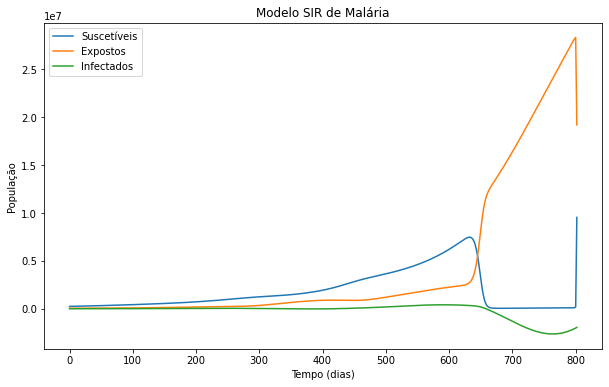

In [26]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -0.3, 1.31, -4.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Diminuir $A$ de -0.03 para -0.3 parece ter quebrado a modelagem, inclusive visto que o modelo parou em $t=800$, e não foi até $t=1825$.

In [27]:
# Novos valores de A, B e C
A_novo = -3
B_novo = 1.31
C_novo = -4.4

# Função para calcular T(t) com os novos valores de A, B e C
def T_novo(t):
    return T1 * (1 + T2 * np.cos(omega1 * t - phi1))

# Calcular mu usando os novos valores de A, B, C e T(t)
def calcular_mu_novo(t):
    return 1 / (A_novo * T_novo(t)**2 + B_novo * T_novo(t) + C_novo)

# Calcular mu para o dado t usando os novos valores de A, B, C
t_valor = 0  # Vamos calcular para t = 0
mu_novo = calcular_mu_novo(t_valor)

print("Novo valor de mu para t = 0:", mu_novo)

Novo valor de mu para t = 0: -0.00048234412357854264


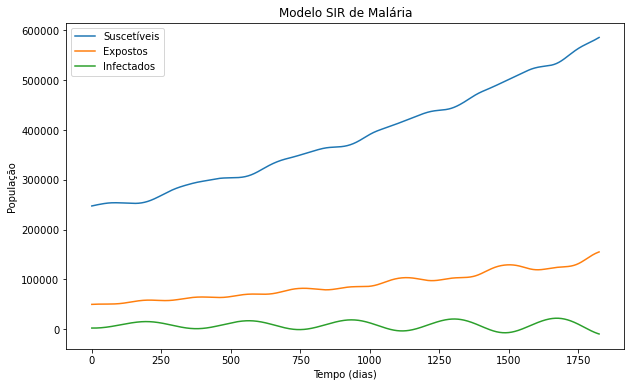

In [28]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -3, 1.31, -4.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Notavelmente, uma taxa negativa de $\mu$ fará com que a população de mosquitos aumente. Ainda assim, pode-se notar que a população de msoquitos infectados costuma flutuar sempre de forma próxima, ocasionalmente ficando negativa.

In [29]:
I_M0

2500

In [30]:
E_M0

50000

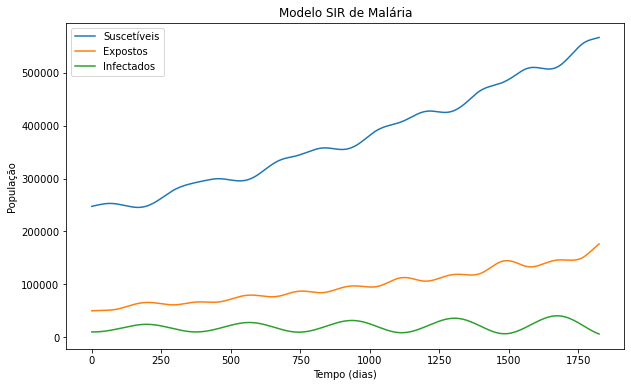

In [31]:
I_M0 = 10000

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -3, 1.31, -4.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [32]:
print(f'A={A}, B={B}, C={C}')

A=317.925000000000, B=15, C=-48.7800000000000


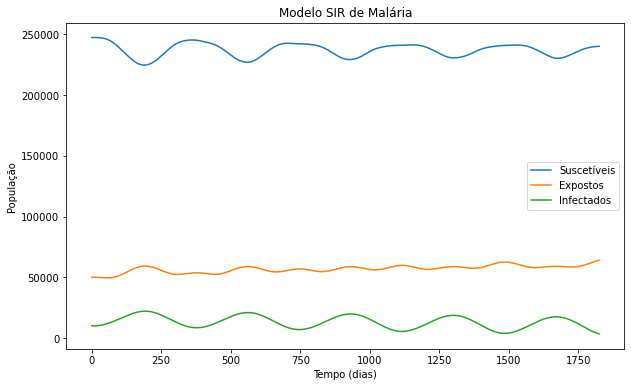

In [33]:
I_M0 = 10000

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [34]:
min(I_M)

3274.720048351728

In [35]:
def model(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T1 - T_curr) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - a_curr * b3_curr * E_M * l_curr
    dImdt = a_curr * b3_curr * E_M * l_curr - mu_curr * I_M
    
    print(a_curr)
    print(b3_curr)
    print(E_M)
    print(l_curr)
    print(' ')
    print(- mu_curr * I_M)
    
#     print(dSmdt)
#     print(dEmdt)
    print(dImdt)
    print(' ')
    
    #print(b_curr - mu_curr*M)
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

-0.0021789541858209358
0.11409077931221394
50000.0
0.9999607429747496
 
-0.22394762600268425
-12.653388721259883
 
-0.0021789417328927493
0.1140907749833389
50000.00024092734
0.9999607429719134
 
-0.22394763137269919
-12.653317279461003
 
-0.002178888683217582
0.11409075654226135
50000.001267281456
0.999960742959831
 
-0.22394765424981417
-12.653012936297513
 
-0.0021788559319050526
0.11409074515728126
50000.00190088675
0.9999607429523716
 
-0.22394766837378394
-12.652825043794394
 
-0.00217880680492268
0.11409072807980644
50000.002851303565
0.9999607429411816
 
-0.223947689565186
-12.652543205030364
 
-0.0021786034491226816
0.11409065738945692
50000.00678525879
0.9999607428948661
 
-0.22394777726345677
-12.651376564831724
 
-0.002178539087649015
0.11409063501618275
50000.00803027893
0.9999607428802065
 
-0.22394780502515454
-12.65100732711415
 
-0.0021786428623012046
0.11409067109022851
50000.00602282776
0.9999607429038424
 
-0.22394776026819327
-12.651602675816033
 
-0.00217857101831

-0.0011319007516347956
0.11372680359461589
71687.00906001938
0.9999605034891298
 
-0.2794113929723742
-9.507133110613195
 
0.0008034084559122374
0.11305405325104001
71698.0253829782
0.9999600554681859
 
-0.2809555070687486
6.231014368287533
 
-0.0005367733924833985
0.11351992598881565
71701.76050045884
0.9999603664645068
 
-0.27993245385791693
-4.648868479748758
 
-0.008208602385372866
0.11618679987682007
70700.92155985437
0.9999620836184235
 
-0.2698939173248387
-67.6970150014296
 
-0.007129832081650658
0.11581179877124044
70956.49522099539
0.9999618484792561
 
-0.271774495029158
-58.85964264507504
 
-0.012135584785491597
0.11755189375876612
69344.47515303694
0.999962922807416
 
-0.2613096155159462
-99.18176376134224
 
-0.014378668684044135
0.11833163244731057
68108.81747380714
0.9999633906295833
 
-0.25469724001400973
-116.13429341256017
 
-0.014378668684044135
0.11833163244731057
68115.78843530703
0.9999633906295833
 
-0.25467787912482887
-116.14613436922608
 
0.004248933196623525
0

0.11772931690452625
63293.617264965804
0.9999630299815717
 
-0.2023461878354604
-94.4305645797032
 
-0.014746634113871605
0.11845954423958394
68382.37250438034
0.9999634665910905
 
-0.2473133318567274
-119.69871773757716
 
-0.01620181445426137
0.11896539264362417
67486.77932032301
0.9999637648633678
 
-0.24135082055485335
-130.31438238876214
 
-0.016303265619272467
0.11900065900098518
63210.241057312436
0.9999637855321151
 
-0.21003307646989197
-122.83973969661459
 
-0.011536397511895068
0.11734360484937302
63453.17112801816
0.9999627964381215
 
-0.20095406691254294
-86.09574196950973
 
-0.01095160650182458
0.11714032035539614
63585.74730285909
0.9999626725285222
 
-0.20047009385885234
-81.76997131279272
 
-0.010039713673622112
0.11682332903892576
63762.64350107862
0.9999624781657644
 
-0.1997154155107856
-74.98237788506144
 
-0.005896614869782266
0.11538310897854334
64548.93011154978
0.9999615771897625
 
-0.19799376020340295
-44.113446178371326
 
-0.004491250397078896
0.11489457751898

 
-0.23472938411350594
-123.80503404293276
 
-0.015286853123586635
0.11864733465724676
70247.63276920865
0.9999635777168915
 
-0.23285148373490885
-127.63945990693915
 
-0.01592057598773707
0.11886762879573715
70087.01173241662
0.9999637074808583
 
-0.2301547832892847
-132.8608838561037
 
-0.01769870366071487
0.11948573984396278
69464.34780208477
0.9999640681763754
 
-0.21879510142941241
-147.1127392511335
 
-0.01796218279802431
0.11957733021074178
69313.94551164043
0.9999641212005786
 
-0.21524876731233233
-149.08724192900175
 
-0.01746479330883515
0.11940442815021411
69577.37332040032
0.9999640210117922
 
-0.22100795488869326
-145.3106090915152
 
-0.017849955932241132
0.11953831801454094
69387.54516941642
0.999964098628594
 
-0.2170094149188112
-148.26762585187132
 
-0.016322746078350738
0.11900743077961713
69424.05341012859
0.9999637894990194
 
-0.19550331511094213
-135.04879279681523
 
-0.0169580693390216
0.11922828124642179
69246.36274284704
0.9999639185438551
 
-0.198320388720601

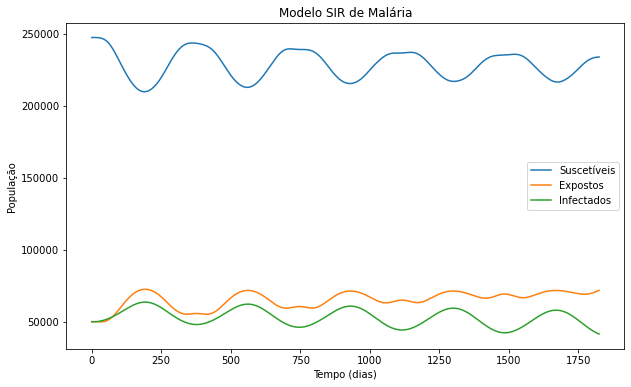

In [36]:
I_M0 = 50000

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

-0.0021789541858209358
0.11409077931221394
50000.0
0.9999607429747496
 
-0.08957905040107371
-12.519020145658272
 
-0.0021789417328927493
0.1140907749833389
50000.00024092734
0.9999607429719134
 
-0.08957905118598165
-12.518948699274286
 
-0.002178888683217874
0.11409075654226145
50000.00126728145
0.999960742959831
 
-0.08957905453000828
-12.518644336579385
 
-0.0021788559319055392
0.11409074515728145
50000.00190088109
0.9999607429523716
 
-0.08957905659488043
-12.518456432016878
 
-0.002178806804923264
0.11409072807980665
50000.002851290825
0.9999607429411816
 
-0.08957905969430542
-12.518174575159671
 
-0.0021786034491244337
0.11409065738945752
50000.00678518668
0.9999607428948661
 
-0.08957907251684548
-12.517007860077246
 
-0.002178539087651059
0.11409063501618345
50000.00803017794
0.9999607428802065
 
-0.08957907657776365
-12.516638598653394
 
-0.002178642862302762
0.11409067109022904
50000.00602277094
0.9999607429038424
 
-0.08957907003224722
-12.517233985574903
 
-0.002178571018

 
0.014894021901351173
0.10815588762476838
57094.555073183044
0.9999565701401781
 
-0.09147566332714861
91.87678757299835
 
0.01808082733641847
0.10704809335448309
57007.094086258294
0.9999557235206439
 
-0.11091172368264693
110.22246489904802
 
0.016960578170564698
0.10743751330261322
61765.10096413459
0.9999560237307132
 
-0.11864198027781851
112.42492023742801
 
0.016960578170564698
0.10743751330261322
59563.22273459906
0.9999560237307132
 
-0.12053636254231515
108.41093463126285
 
-0.004093261902557884
0.11475622913755583
58270.61230107319
0.9999611756365654
 
-0.07481495960256963
-27.445049719130147
 
0.00019702707360954875
0.11326484296965
58418.59236131241
0.9999601966005631
 
-0.07488194190951687
1.2287495269727329
 
0.017797792345378944
0.10714648170851111
57049.50201989858
0.999955799638796
 
-0.1046628830157838
108.68226481421674
 
0.016060618032837284
0.10775035658858513
60258.31256692046
0.9999562628558505
 
-0.12393619429318257
104.15076167031138
 
0.015518162793193279
0.

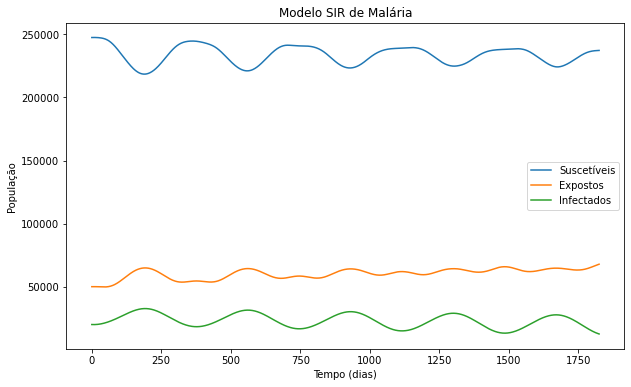

In [37]:
I_M0 = 20000

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [38]:
min(I_M)

12510.869384939475

In [39]:
I_M[0]

20000.0

In [40]:
I_M[-1]

12510.869384939475

In [41]:
def T(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))
    
T0 = T(0)
T0

26.479531827782463

In [42]:
M = 300000
a0 = (T1 - T0) / D1
b1 = 0.1
b2 = 0.3
p0 = np.exp(-1 / (A*T0**2 + B*T0 + C))
tau_M0 = DD / (T0 - Tmin)
l0 = p0**tau_M0
gamma = 1/1825
mu0 = -log(p0)
N = 8558

In [43]:
R0 = (M*(a0**2)*b1*b2*l0)/(gamma*mu0*N)
R0

2034.397370927539

Analisando o artigo original, foi notado que existem dois $T_1$ distintos, um usado no cálculo de $a(T)$ e um na equação de $T(t)$ em si. Para isso, o $T_1$ de $a(T)$ foi chamado de $T'$. Como estava sendo usado o mesmo valor de $T_1$ para ambos, foi verificado como aumentar ou diminuir esse valor para $T'$ afeta o modelo.

In [44]:
def model(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_linha - T_curr) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - a_curr * b3_curr * E_M * l_curr
    dImdt = a_curr * b3_curr * E_M * l_curr - mu_curr * I_M
    
#     print(dSmdt)
#     print(dEmdt)
#     print(dImdt)
#     print(' ')
    
    #print(b_curr - mu_curr*M)
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [45]:
T_linha = 28
T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=36.5
b1=0.1

A=317.925
B=15
C=-48.78

b2=0.3
tau_H=10
DD=105
Tmin=14.5
gamma= 1/1825 
R_L = 312
N = 8558
M = 300000 
E_M0 = 50000
I_H0 = 1000 
I_M0 = 2500
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0 - I_M0

In [46]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

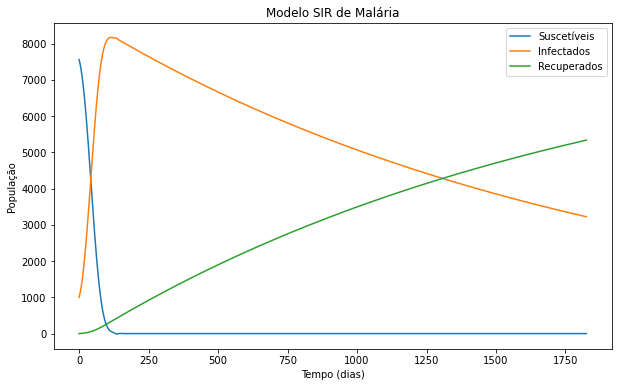

In [47]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [48]:
args = (26, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

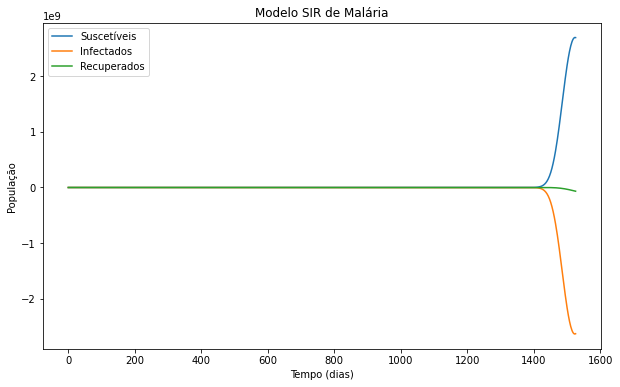

In [49]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

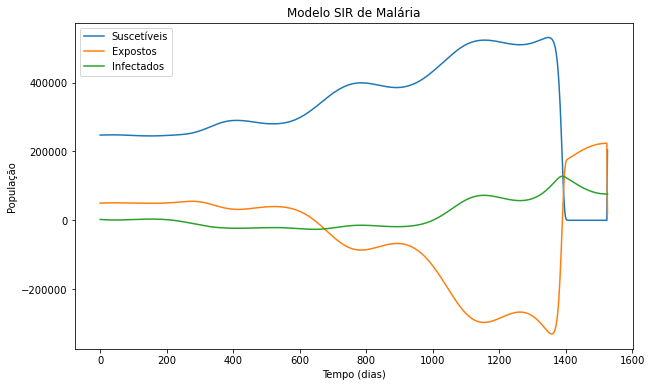

In [50]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Novamente, é possível ver que o modelo quebrou, ao parar antes de $t=1825$

In [51]:
args = (26.5, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

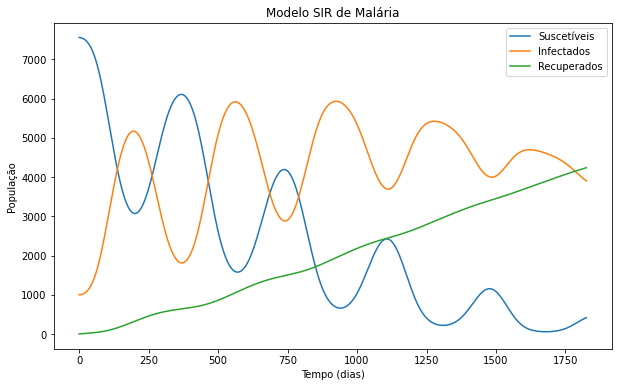

In [52]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

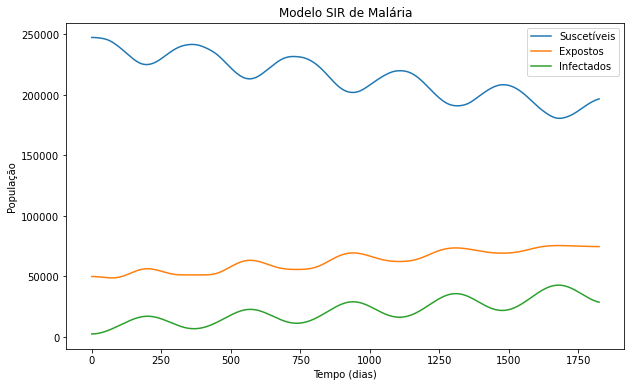

In [53]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [54]:
args = (26.7, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

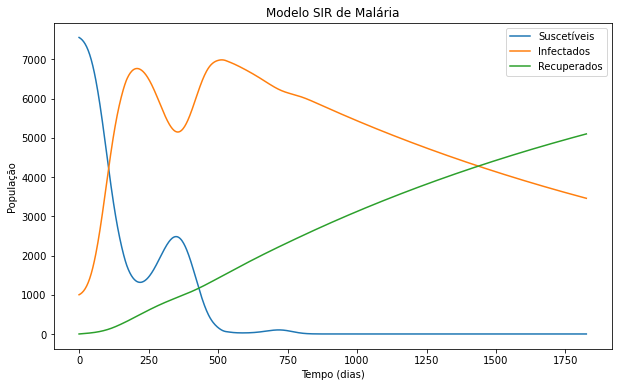

In [55]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

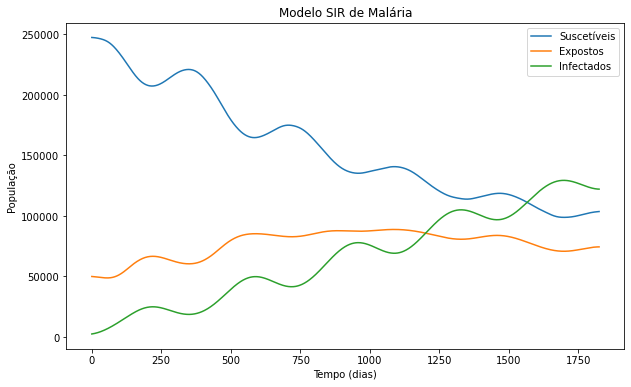

In [56]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()